In [17]:
import fire
import torch, os, random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


class CIFAR10CannyEdgeDataset(Dataset):
    def __init__(self, root, train=True, download=True, apply_imagenet_normalization=False):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=download)
        
        transform_list = [
            transforms.Resize((120, 160)),  # Resizing to a larger size for demonstration purposes
            transforms.ToTensor()
        ]
        
        if apply_imagenet_normalization:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            transform_list.append(normalize)
        
        self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = image.convert('RGB')  # Ensure the image is in RGB mode
        image_tensor = self.transform(image)

        # Convert image to grayscale and to numpy array for Canny edge detection
        gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        gray_image = cv2.resize(gray_image, (160, 120))  # Resizing to match the resized RGB image

        edges = cv2.Canny(gray_image, 100, 200)
        edges_tensor = torch.tensor(edges, dtype=torch.float32).unsqueeze(0) / 255.0

        return image_tensor, edges_tensor
    
    
class CIFAR10CannyEdgeDoubleImageDataset(Dataset):
    def __init__(self, root, train=True, download=True, apply_imagenet_normalization=False):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=download)
        
        transform_list = [
            transforms.Resize((120, 160)),  # Resizing to a larger size for demonstration purposes
            transforms.ToTensor()
        ]
        
        if apply_imagenet_normalization:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            transform_list.append(normalize)
        
        self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the first image
        x0, label1 = self.dataset[idx]
        x0 = x0.convert('RGB')  # Ensure the image is in RGB mode
        x0_tensor = self.transform(x0)

        # Randomly select another image
        idx2 = random.randint(0, len(self.dataset) - 1)
        x1, label2 = self.dataset[idx2]
        x1 = x1.convert('RGB')
        x1_tensor = self.transform(x1)

        # Convert the second image to grayscale and to numpy array for Canny edge detection
        gray_x1 = cv2.cvtColor(np.array(x1), cv2.COLOR_RGB2GRAY)
        gray_x1 = cv2.resize(gray_x1, (160, 120))  # Resizing to match the resized RGB image

        edges2 = cv2.Canny(gray_x1, 100, 200)
        edges2_tensor = torch.tensor(edges2, dtype=torch.float32).unsqueeze(0) / 255.0

        return x0_tensor, x1_tensor, edges2_tensor
    

class UnpairedCIFAR10SimImages(Dataset):
    def __init__(self, cifar10_root, sim_images_dir, apply_imagenet_normalization=False):
        self.cifar10_dataset = datasets.CIFAR10(root=cifar10_root, train=True, download=True)
        self.sim_images_dir = sim_images_dir
        self.sim_images_files = [f for f in os.listdir(sim_images_dir) if f.endswith('.png')]
        
        transform_list = [
            transforms.Resize((120, 160)),  # Resize to 160x120
            transforms.ToTensor()
        ]
        
        if apply_imagenet_normalization:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            transform_list.append(normalize)
        
        self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return len(self.sim_images_files)

    def __getitem__(self, idx):
        # Randomly select an image from CIFAR-10
        cifar_idx = random.randint(0, len(self.cifar10_dataset) - 1)
        x0, _ = self.cifar10_dataset[cifar_idx]
        x0 = x0.convert('RGB')  # Ensure the image is in RGB mode
        x0_tensor = self.transform(x0)

        # Get the corresponding sim image
        sim_image_path = os.path.join(self.sim_images_dir, self.sim_images_files[idx])
        x1 = Image.open(sim_image_path).convert('RGB')
        x1_tensor = self.transform(x1)

        # Convert the sim image to grayscale and to numpy array for Canny edge detection
        gray_x1 = cv2.cvtColor(np.array(x1), cv2.COLOR_RGB2GRAY)
        gray_x1 = cv2.resize(gray_x1, (160, 120))  # Resize to match the resized RGB image

        x1_canny = cv2.Canny(gray_x1, 100, 200)
        x1_canny_tensor = torch.tensor(x1_canny, dtype=torch.float32).unsqueeze(0) / 255.0

        return x0_tensor, x1_tensor, x1_canny_tensor

In [18]:
cifar_root = '/data/cifar10'
sim_root = '/data/real_to_sim_data/unpaired_sim_images/imagedata'

cifar10_canny_edge_dataset = CIFAR10CannyEdgeDataset(cifar_root, train=True, download=False)
cifar10_canny_edge_double_image_dataset = CIFAR10CannyEdgeDoubleImageDataset(cifar_root, train=True, download=False)
cifar10_sim_images_dataset = UnpairedCIFAR10SimImages(cifar_root, sim_root)

Files already downloaded and verified


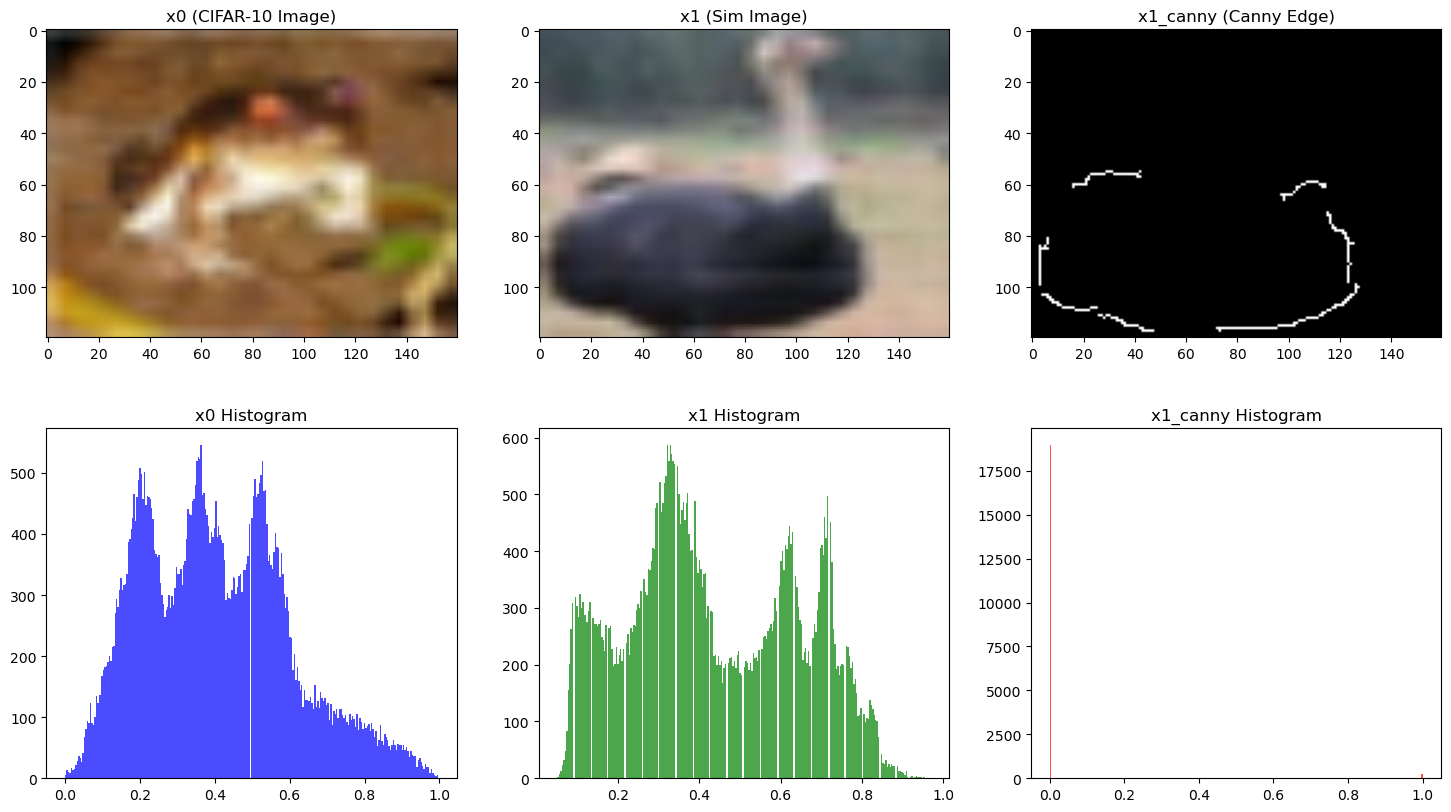

In [20]:
x0, x1, x1_canny = cifar10_canny_edge_double_image_dataset[0]


plt.figure(figsize=(18, 10))

# Convert tensors to numpy arrays for visualization
x0_np = x0.permute(1, 2, 0).numpy()
x1_np = x1.permute(1, 2, 0).numpy()
x1_canny_np = x1_canny.squeeze(0).numpy()  # Remove the channel dimension for the grayscale image

# Plot x0
plt.subplot(2, 3, 1)
plt.imshow(x0_np)
plt.title("x0 (CIFAR-10 Image)")

# Histogram for x0
plt.subplot(2, 3, 4)
plt.hist(x0_np.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("x0 Histogram")

# Plot x1
plt.subplot(2, 3, 2)
plt.imshow(x1_np)
plt.title("x1 (Sim Image)")

# Histogram for x1
plt.subplot(2, 3, 5)
plt.hist(x1_np.ravel(), bins=256, color='green', alpha=0.7)
plt.title("x1 Histogram")

# Plot x1_canny
plt.subplot(2, 3, 3)
plt.imshow(x1_canny_np, cmap='gray')
plt.title("x1_canny (Canny Edge)")

# Histogram for x1_canny
plt.subplot(2, 3, 6)
plt.hist(x1_canny_np.ravel(), bins=256, color='red', alpha=0.7)
plt.title("x1_canny Histogram")

plt.show()

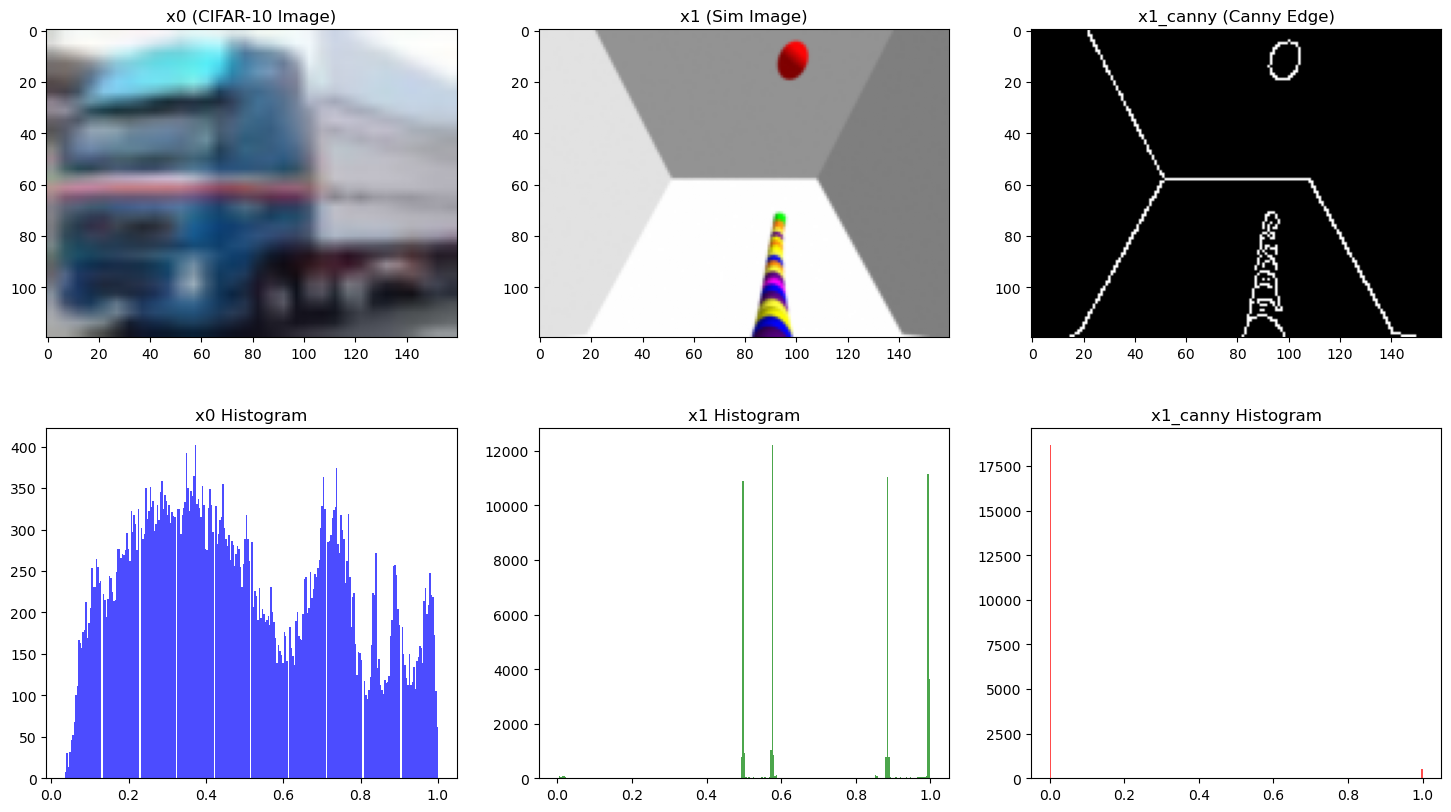

In [19]:
x0, x1, x1_canny = cifar10_sim_images_dataset[1]

plt.figure(figsize=(18, 10))

# Convert tensors to numpy arrays for visualization
x0_np = x0.permute(1, 2, 0).numpy()
x1_np = x1.permute(1, 2, 0).numpy()
x1_canny_np = x1_canny.squeeze(0).numpy()  # Remove the channel dimension for the grayscale image

# Plot x0
plt.subplot(2, 3, 1)
plt.imshow(x0_np)
plt.title("x0 (CIFAR-10 Image)")

# Histogram for x0
plt.subplot(2, 3, 4)
plt.hist(x0_np.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("x0 Histogram")

# Plot x1
plt.subplot(2, 3, 2)
plt.imshow(x1_np)
plt.title("x1 (Sim Image)")

# Histogram for x1
plt.subplot(2, 3, 5)
plt.hist(x1_np.ravel(), bins=256, color='green', alpha=0.7)
plt.title("x1 Histogram")

# Plot x1_canny
plt.subplot(2, 3, 3)
plt.imshow(x1_canny_np, cmap='gray')
plt.title("x1_canny (Canny Edge)")

# Histogram for x1_canny
plt.subplot(2, 3, 6)
plt.hist(x1_canny_np.ravel(), bins=256, color='red', alpha=0.7)
plt.title("x1_canny Histogram")

plt.show()


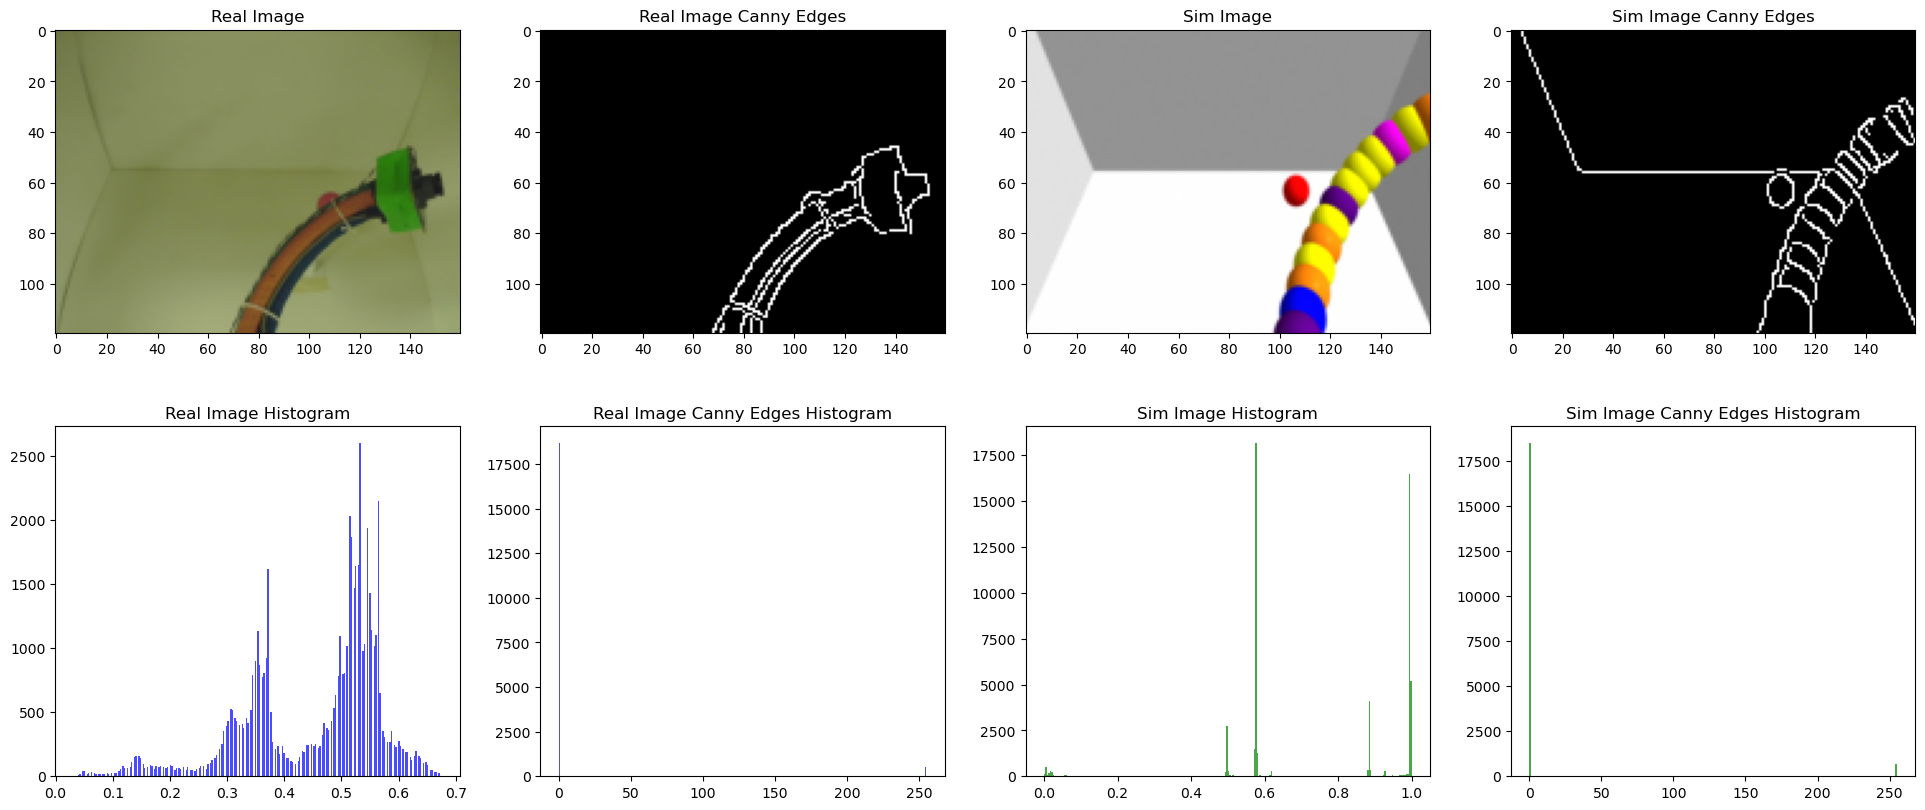

In [22]:
# Load the images
real_img_path = '/data/real_to_sim_data/paired_real_sim_images/example/tip_step_1.jpg'
sim_img_path = '/data/real_to_sim_data/paired_real_sim_images/example/world_1.png'

real_img = Image.open(real_img_path).convert('RGB')
sim_img = Image.open(sim_img_path).convert('RGB')

# Resize to match dimensions if needed
resize_transform = transforms.Resize((120, 160))  # Resize to 120x160
real_img = resize_transform(real_img)
sim_img = resize_transform(sim_img)

# Convert the images to tensors and normalize to [0, 1]
to_tensor = transforms.ToTensor()
real_img_tensor = to_tensor(real_img)
sim_img_tensor = to_tensor(sim_img)

# Convert the tensors back to PIL Images for Canny edge detection
real_img_pil = transforms.ToPILImage()(real_img_tensor)
sim_img_pil = transforms.ToPILImage()(sim_img_tensor)

# Convert PIL images to numpy arrays for OpenCV
real_img_np = np.array(real_img_pil)
sim_img_np = np.array(sim_img_pil)

# Convert to grayscale for Canny edge detection
real_gray = cv2.cvtColor(real_img_np, cv2.COLOR_RGB2GRAY)
sim_gray = cv2.cvtColor(sim_img_np, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detection
real_edges = cv2.Canny(real_gray, 100, 200)
sim_edges = cv2.Canny(sim_gray, 100, 200)

# Plot the images and their histograms
plt.figure(figsize=(24, 10))

# Convert tensors to numpy arrays for visualization
real_img_np = real_img_tensor.permute(1, 2, 0).numpy()
sim_img_np = sim_img_tensor.permute(1, 2, 0).numpy()

# Plot real image
plt.subplot(2, 4, 1)
plt.imshow(real_img_np)
plt.title("Real Image")

# Histogram for real image
plt.subplot(2, 4, 5)
plt.hist(real_img_np.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Real Image Histogram")

# Plot real image Canny edges
plt.subplot(2, 4, 2)
plt.imshow(real_edges, cmap='gray')
plt.title("Real Image Canny Edges")

# Histogram for real image Canny edges
plt.subplot(2, 4, 6)
plt.hist(real_edges.ravel(), bins=256, color='blue', alpha=0.7)
plt.title("Real Image Canny Edges Histogram")

# Plot sim image
plt.subplot(2, 4, 3)
plt.imshow(sim_img_np)
plt.title("Sim Image")

# Histogram for sim image
plt.subplot(2, 4, 7)
plt.hist(sim_img_np.ravel(), bins=256, color='green', alpha=0.7)
plt.title("Sim Image Histogram")

# Plot sim image Canny edges
plt.subplot(2, 4, 4)
plt.imshow(sim_edges, cmap='gray')
plt.title("Sim Image Canny Edges")

# Histogram for sim image Canny edges
plt.subplot(2, 4, 8)
plt.hist(sim_edges.ravel(), bins=256, color='green', alpha=0.7)
plt.title("Sim Image Canny Edges Histogram")

plt.show()